In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

covid_data = pd.read_csv("datasets/ds.csv")

# Remove timestamps
covid_data = covid_data.drop(covid_data.columns[0], axis=1)

# Pick goal column
y_df = covid_data.iloc[ : , 155]
covid_data = covid_data.drop(covid_data.columns[155], axis=1)

# Generalized influence index
col_1 = covid_data.sum(axis = 1, skipna = True) 

# Two features dataset
covid_data = pd.concat([col_1, y_df], axis=1)
covid_data.columns = ['Influence', 'Cases']

In [3]:
covid_data.head()

,Influence,Cases
0,0.001957,0
1,0.005700,17
2,0.005453,42
3,0.006956,93
4,0.007554,74


In [0]:
input_feature = covid_data.values

In [0]:
# Flip for time lag algorithm (latest --> oldest)
input_feature_0 = np.flip(covid_data.Influence.values)
input_feature_1 = np.flip(covid_data.Cases.values)
input_data = np.zeros(input_feature.shape)

# Gently handmade normalization
input_data[:,0] = (input_feature_0 - np.amin(input_feature_0)) / (np.amax(input_feature_0) - np.amin(input_feature_0))
input_data[:,1] = (input_feature_1 - np.amin(input_feature_1)) / (np.amax(input_feature_1) - np.amin(input_feature_1))

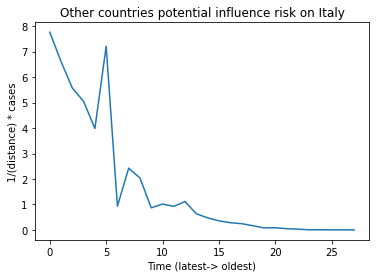

In [6]:
plt.plot(input_feature_0)
plt.title("Other countries potential influence risk on Italy")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("1/(distance) * cases")
plt.show()

In [0]:
lookback = 7

test_size=int(.5 * len(covid_data))
X=[]
y=[]

# Sliding window
for i in range(len(covid_data)-lookback-1):

    '''
      Schema:
                ---------------------
                Day 0                 y
                ---------------------
                Day 1
                Day 2
                Day 3                 x
                Day 4
                Day 5
                Day 6
                Day 7
                ---------------------
    '''
    
    t = []

    # From i ---> next lookback days
    for j in range(1,lookback+1):
        # pick all columns, but i + looknext (future) + lookback (sliding through the past for each record)
        t.append(input_data[[(i+j)], :])

    # One batch is each record + the past lookback days windows
    X.append(t)

    # Looks at cases only, picks
    # y.append(input_data[i+ lookback,1])

    # Current day is the result, we train the model based on the previous lookback days
    y.append(input_data[i,:])

In [8]:
X, y = np.array(X), np.array(y)

# picks % test from top - lookback for windowing
X_test = X[:test_size+lookback]
y_test = y[:test_size+lookback]

X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)

print(X.shape)
print(X_test.shape)

(20, 7, 2)
(20, 7, 2)


In [9]:
from keras import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=2))

Using TensorFlow backend.


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.fit(X, y, epochs=500, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/500





20/20 [==============================] - 2s 77ms/step - loss: 0.1989
Epoch 2/500
20/20 [==============================] - 0s 903us/step - loss: 0.1930
Epoch 3/500
20/20 [==============================] - 0s 854us/step - loss: 0.1871
Epoch 4/500
20/20 [==============================] - 0s 794us/step - loss: 0.1812
Epoch 5/500
20/20 [==============================] - 0s 770us/step - loss: 0.1751
Epoch 6/500
20/20 [==============================] - 0s 819us/step - loss: 0.1687
Epoch 7/500
20/20 [==============================] - 0s 808us/step - loss: 0.1621
Epoch 8/500
20/20 [==============================] - 0s 767us/step - loss: 0.1552
Epoch 9/500
20/20 [==============================] - 0s 774us/step - loss: 0.1478
Epoch 10/500
20/20 [==============================] - 0s 824us/step - loss: 0.1401
Epoch 11/500
20/20 [==============================] - 0s 841us/step - loss: 0.

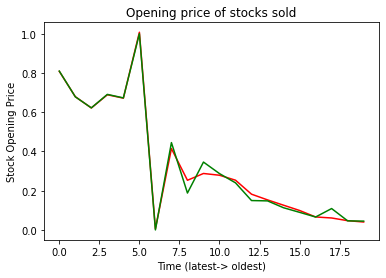

In [12]:
predicted_value= model.predict(X_test)
plt.plot(predicted_value[:,1], color= 'red')
plt.plot(y_test[:,1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

# whoops, the plot title is a copy and paste mistake.

In [0]:
from copy import deepcopy

future_days = 4
past_predict_week = np.asarray([input_data[:lookback]])
predicted_week = []

# New day prediction
for i in range(0, future_days):
  new_day = model.predict(past_predict_week)[0]
  
  # Store prediction
  predicted_week.append(new_day)

  # Feed new week
  new_week = np.zeros((7,2))
  new_week[0,:] = new_day
  
  for x in range(1, past_predict_week.shape[1]):
    new_week[x,:] = past_predict_week[0][x]
  
  past_predict_week = np.asarray([new_week])
  
# Reverse in oldest -> latest order
predicted_week = np.flip(np.asarray(predicted_week))

# Reverse Normalization
cases = (predicted_week[:,1] * (np.amax(input_feature_1) - np.amin(input_feature_1))) + (np.amin(input_feature_0))

In [14]:
cases

array([8680.682 , 7974.801 , 7368.8203, 6611.262 ], dtype=float32)

In [0]:
# Reverse Norm. to plot problem data
input_cases = (input_data[:,1] * (np.amax(input_feature_1) - np.amin(input_feature_1))) + (np.amin(input_feature_0))

In [0]:
input_cases = np.concatenate((np.flip(input_cases), cases), axis=0)

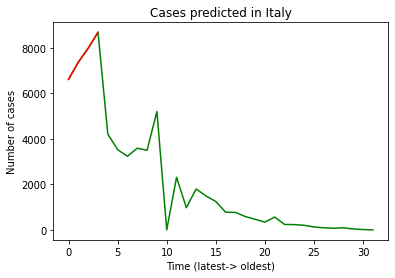

In [19]:
plt.plot(np.flip(input_cases), color= 'green')
plt.plot(np.flip(cases), color='red')
plt.title("Cases predicted in Italy")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Number of cases")
plt.show()